## This notebook contains a sample code for the synthetic data experiment in Section 5.1.

Before running the code, please check README.md and install LEMON.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
import stealth_sampling

### Functions

In [2]:
# split data to bins (s, y) = (1, 1), (1, 0), (0, 1), (0, 0)
def split_to_four(X, S, Y):
    Z = np.c_[X, S, Y]
    Z_pos_pos = Z[np.logical_and(S, Y), :]
    Z_pos_neg = Z[np.logical_and(S, np.logical_not(Y)), :]
    Z_neg_pos = Z[np.logical_and(np.logical_not(S), Y), :]
    Z_neg_neg = Z[np.logical_and(np.logical_not(S), np.logical_not(Y)), :]
    Z = [Z_pos_pos, Z_pos_neg, Z_neg_pos, Z_neg_neg]
    return Z

# compute demographic parity
def demographic_parity(W):
    p_pos = np.mean(np.concatenate(W[:2]))
    p_neg = np.mean(np.concatenate(W[2:]))
    return np.abs(p_pos - p_neg)

# compute the sampling size from each bin
def computeK(Z, Nsample, sampled_spos, sampled_ypos):
    Kpp = Nsample*sampled_spos*sampled_ypos[0]
    Kpn = Nsample*sampled_spos*(1-sampled_ypos[0])
    Knp = Nsample*(1-sampled_spos)*sampled_ypos[1]
    Knn = Nsample*(1-sampled_spos)*(1-sampled_ypos[1])
    K = [Kpp, Kpn, Knp, Knn]
    kratio = min([min(1, z.shape[0]/k) for (z, k) in zip(Z, K)])
    Kpp = int(np.floor(Nsample*kratio*sampled_spos*sampled_ypos[0]))
    Kpn = int(np.floor(Nsample*kratio*sampled_spos*(1-sampled_ypos[0])))
    Knp = int(np.floor(Nsample*kratio*(1-sampled_spos)*sampled_ypos[1]))
    Knn = int(np.floor(Nsample*kratio*(1-sampled_spos)*(1-sampled_ypos[1])))
    K = [max([k, 1]) for k in [Kpp, Kpn, Knp, Knn]]
    return K

# case-contrl sampling
def case_control_sampling(X, K):
    q = [(K[i]/sum(K)) * np.ones(x.shape[0]) / x.shape[0] for i, x in enumerate(X)]
    return q

# synthetic data generation
def gen_data(N, d, spos=0.5, ypos_coef=0.2, seed=0):
    np.random.seed(seed)
    X = np.random.rand(N, d)
    S = (np.random.rand(N) < spos)
    Y = X[:, 0] + ypos_coef * S > 0.5
    return X, S, Y

### Experiment

In [3]:
# experiment function
def sample_and_evaluate(N, Nref, Nsample, d, spos=0.5, ypos_coef=0.2, sampled_spos=0.5, sampled_ypos=[0.6, 0.6], significance=0.05, seed=0):
    # data generation
    X, S, Y = gen_data(N, d, spos=spos, ypos_coef=ypos_coef, seed=seed)
    Xref, Sref, Yref = gen_data(Nref, d, spos=spos, ypos_coef=ypos_coef, seed=seed+1)

    # demographic parity of the original data
    Z = split_to_four(X, S, Y)
    parity = demographic_parity([z[:, -1] for z in Z])

    # sampling
    results = [[parity, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]]
    K = computeK(Z, Nsample, sampled_spos, sampled_ypos)
    for i, sampling in enumerate(['case-control', 'stealth']):
        np.random.seed(seed+i)
        if sampling == 'case-control':
            p = case_control_sampling([z[:, :-1] for z in Z], K)
        elif sampling == 'stealth':
            p = stealth_sampling.stealth_sampling([z[:, :-1] for z in Z], K, path='./', prefix='stealth', timeout=10.0)
        idx = np.random.choice(N, sum(K), p=np.concatenate(p), replace=False)
        Xs = np.concatenate([z[:, :-2] for z in Z], axis=0)[idx, :]
        Ss = np.concatenate([z[:, -2] for z in Z], axis=0)[idx]
        Ts = np.concatenate([z[:, -1] for z in Z], axis=0)[idx]

        # demographic parity of the sampled data
        Zs = split_to_four(Xs, Ss, Ts)
        parity = demographic_parity([z[:, -1] for z in Zs])

        # Kolmogorov-Smirnov two-sample test by complainer
        test_res = ks_2samp(Xs[:, 0], Xref[:, 0])
        test_pos = ks_2samp(Xs[Ss>0.5, 0], Xref[Sref>0.5, 0])
        test_neg = ks_2samp(Xs[Ss<0.5, 0], Xref[Sref<0.5, 0])
        reject = test_res[1] < significance
        reject_pos = test_pos[1] < significance
        reject_neg = test_neg[1] < significance

        results.append([parity, test_res[1], reject, test_pos[1], reject_pos, test_neg[1], reject_neg])
    return results

In [4]:
# parameter settings for data
seed = 0                    # random seed
spos = 0.5                  # Pr[s=1] in data generation
ypos_coef = 0.2             # 'a' of the decisoin-maker's criteria in Eq(5.2)
d = 1                       # dimensionality of the feature x
N = 1000                    # number of data

# parameter settings for sampling
Nsample = 200               # number of data to sample
sampled_spos = 0.5          # Pr[s=1] in sampling
sampled_ypos = [0.6, 0.6]   # the ratio of positive decisions '\alpha' in sampling

# parameter settings for complainer
Nref = 200                  # number of referential data
significance = 0.05         # significance level in Kolmogorov-Smirnov two-samle test

#### Experiment (One Run)

In [5]:
results = sample_and_evaluate(N, Nref, Nsample, d, spos=spos, ypos_coef=ypos_coef, sampled_spos=sampled_spos, sampled_ypos=sampled_ypos, significance=significance, seed=seed)
df = pd.DataFrame(results)
df.index = ['Original', 'Case-control', 'Stealth']
df.columns = [['', 'Pr[x]', 'Pr[x]', 'Pr[x|s=1]', 'Pr[x|s=1]', 'Pr[x|s=0]', 'Pr[x|s=0]'], ['DP', 'p-value', 'rejected', 'p-value', 'rejected', 'p-value', 'rejected']]
print('Result (d = %d, alpha = %.2f, seed=%d)' % (d, sampled_ypos[0], seed))
df

Result (d = 1, alpha = 0.60, seed=0)


Pr[x]          Pr[x|s=1]          Pr[x|s=0]  \
                    DP   p-value rejected   p-value rejected   p-value   
Original      0.214770       NaN      NaN       NaN      NaN       NaN   
Case-control  0.002404  0.062286    False  0.552861    False  0.002151   
Stealth       0.088209  0.376659    False  0.171742    False  0.288065   

                       
             rejected  
Original          NaN  
Case-control     True  
Stealth         False

#### Experiment (10 Runs)

In [6]:
num_itr = 10
result_all = []
for i in range(num_itr):
    result_i = sample_and_evaluate(N, Nref, Nsample, d, spos=spos, ypos_coef=ypos_coef, sampled_spos=sampled_spos, sampled_ypos=sampled_ypos, significance=significance, seed=i)
    result_all.append(result_i)
result_all = np.array(result_all)
df = pd.DataFrame(np.mean(result_all, axis=0))
df.index = ['Original', 'Case-control', 'Stealth']
df.columns = [['', 'Pr[x]', 'Pr[x]', 'Pr[x|s=1]', 'Pr[x|s=1]', 'Pr[x|s=0]', 'Pr[x|s=0]'], ['DP', 'p-value', 'rejected ratio', 'p-value', 'rejected ratio', 'p-value', 'rejected ratio']]
print('Average Result of %d runs (d = %d, alpha = %.2f)' % (num_itr, d, sampled_ypos[0]))
df

Average Result of 10 runs (d = 1, alpha = 0.60)


Pr[x]                Pr[x|s=1]                 \
                    DP   p-value rejected ratio   p-value rejected ratio   
Original      0.200068       NaN            NaN       NaN            NaN   
Case-control  0.031579  0.527264            0.0  0.480034            0.0   
Stealth       0.074317  0.578463            0.0  0.520069            0.0   

             Pr[x|s=0]                 
               p-value rejected ratio  
Original           NaN            NaN  
Case-control  0.306263            0.2  
Stealth       0.532285            0.1

#### Experiment with 30 runs for several different alpha

In [7]:
num_itr = 30 # <- chage 100 for the full result
alphas = np.linspace(0.4, 0.8, 5) # <- change to np.linspace(0.4, 0.8, 11) for the full reslt
result_all = []
for alpha in alphas:
    sampled_ypos = [alpha, alpha]
    result_sub = []
    for i in range(num_itr):
        result_i = sample_and_evaluate(N, Nref, Nsample, d, spos=spos, ypos_coef=ypos_coef, sampled_spos=sampled_spos, sampled_ypos=sampled_ypos, significance=significance, seed=i)
        result_sub.append(result_i)
    result_all.append(result_sub)
result_all = np.array(result_all)

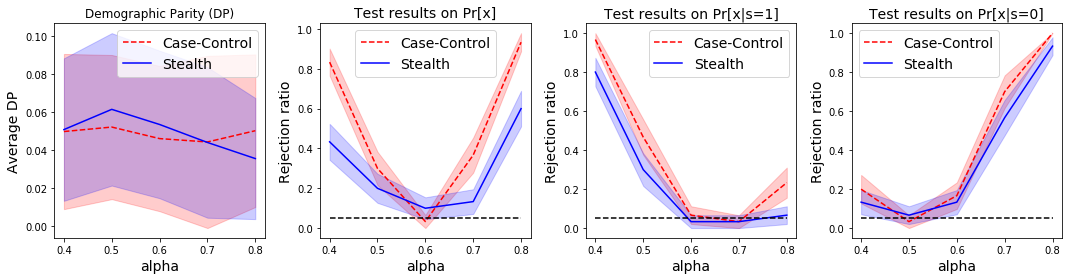

In [8]:
result_average = np.mean(result_all, axis=1)
result_std = np.std(result_all, axis=1)
test_names = ['Pr[x]', 'Pr[x|s=1]', 'Pr[x|s=0]']
plt.figure(figsize=(15, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        shade1 = result_std[:, 1, 2*i]
        shade2 = result_std[:, 2, 2*i]
    else:
        shade1 = np.sqrt(result_average[:, 1, 2*i] * (1 - result_average[:, 1, 2*i]) / num_itr)
        shade2 = np.sqrt(result_average[:, 2, 2*i] * (1 - result_average[:, 2, 2*i]) / num_itr)
    plt.fill_between(alphas, result_average[:, 1, 2*i]-shade1, result_average[:, 1, 2*i]+shade1, color='r', alpha=0.2)
    plt.fill_between(alphas, result_average[:, 2, 2*i]-shade2, result_average[:, 2, 2*i]+shade2, color='b', alpha=0.2)
    plt.plot(alphas, result_average[:, 1, 2*i], 'r--')
    plt.plot(alphas, result_average[:, 2, 2*i], 'b-')
    if i == 0:
        plt.xlabel('alpha', fontsize=14)
        plt.ylabel('Average DP', fontsize=14)
        plt.title('Demographic Parity (DP)')
    else:
        plt.plot(alphas, [significance]*alphas.size, 'k--')
        plt.xlabel('alpha', fontsize=14)
        plt.ylabel('Rejection ratio', fontsize=14)
        plt.title('Test results on %s' % (test_names[i-1],), fontsize=14)
    plt.legend(['Case-Control', 'Stealth'], fontsize=14)
plt.tight_layout()
plt.show()